In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
#plt.style.use('dark_background')

# Parameters
L = 4000
x = np.arange(L)
dx = 1
x0 = 200  
sigma = 20  
a = 700  # Transition width
t_max = 2 
E_values = [0.01, 0.1, 0.2]  # Energy values
x_horizon = 3000/2 + a*np.arctanh(1/t_max) # Horizon position
colors = ['cyan', 'lime', 'magenta']

wkb_results = {} # Storage for WKB solutions

In [2]:
for i, E in enumerate(E_values):
    print(f"\nAnalyzing E = {E}")
    
    t_norm = np.tanh((x0 - x_horizon)/a)
    t = t_max * (np.tanh((x - x_horizon)/a) - t_norm) / (1 - t_norm) # tilt profile t(x)
    
    # Initialize arrays for WKB quantities
    k_local = np.zeros(L, dtype=complex)
    v_g = np.zeros(L, dtype=complex)
    S_phase = np.zeros(L, dtype=complex)
    A_amplitude = np.zeros(L, dtype=complex)
    psi_wkb = np.zeros(L, dtype=complex)
    
    x0_idx = int(x0) # Get x0 index once
    
    # Newton-Raphson for k(x)
    print("  Calculating k(x) via manual Newton-Raphson")
    
    # Find initial k at x0
    k_current = min(max(E, 0.05), 0.5)  # Initial guess
    print(f"  Initial guess from energy: k = {k_current:.4f} for E = {E}")
    converged_x0 = False
    
    for newton_iter in range(100):  # Max iterations
        # Calculate f(k) = E₂(k,x) - E directly
        sin_k = np.sin(k_current)
        cos_k = np.cos(k_current)
        term1 = np.sqrt(sin_k**2 + (1 - cos_k)**2)
        f_value = term1 - t[x0_idx] * sin_k - E # E = E₂(k, x)
        
        # Calculate f'(k) = dE₂/dk manually
        if abs(term1) < 1e-12:
            denominator = 1e-12
        else:
            denominator = term1
        df_dk = sin_k / denominator - t[x0_idx] * cos_k #is actually the group velocity
        
        if abs(df_dk) < 1e-12: # Avoid division by zero
            k_local[x0_idx] = np.nan
            break
            
        k_new = k_current - f_value / df_dk # Newton update
        
        if abs(k_new - k_current) < 1e-12:
            k_local[x0_idx] = k_new
            converged_x0 = True  # Check convergence
            break
            
        k_current = k_new
    else:
        k_local[x0_idx] = np.nan
    
    if converged_x0:
        print(f"  Found initial k(x0) = {k_local[x0_idx]:.6f}")
    else:
        print("  WARNING: Could not find initial k(x0)")
        k_local[x0_idx] = np.nan
    
    # Calculate k(x) for positions to the right of x0
    if not np.isnan(k_local[x0_idx]):
        current_k_guess = k_local[x0_idx]
        for j in range(x0_idx + 1, L):
            k_current = current_k_guess
            converged = False
            
            for newton_iter in range(100):
                # Calculate f(k) directly
                sin_k = np.sin(k_current)
                cos_k = np.cos(k_current)
                term1 = np.sqrt(sin_k**2 + (1 - cos_k)**2)
                f_value = term1 - t[j] * sin_k - E
                
                if abs(term1) < 1e-12:
                    denominator = 1e-12
                else:
                    denominator = term1
                df_dk = sin_k / denominator - t[j] * cos_k # Calculate f'(k) directly
                
                if abs(df_dk) < 1e-12: # Avoid division by zero
                    k_local[j] = np.nan
                    break
                    
                k_new = k_current - f_value / df_dk
                
                if abs(k_new - k_current) < 1e-12:
                    k_local[j] = k_new
                    current_k_guess = k_new
                    converged = True
                    break
                    
                k_current = k_new
            else:
                k_local[j] = np.nan
                
                
            if not converged:
                k_local[j] = np.nan
    
    # Calculate k(x) for positions to the LEFT of x0  
    if not np.isnan(k_local[x0_idx]):
        current_k_guess = k_local[x0_idx]
        for j in range(x0_idx - 1, -1, -1):
            k_current = current_k_guess
            converged = False
            
            for newton_iter in range(100):
                # Calculate f(k) directly
                sin_k = np.sin(k_current)
                cos_k = np.cos(k_current)
                term1 = np.sqrt(sin_k**2 + (1 - cos_k)**2)
                f_value = term1 - t[j] * sin_k - E
                
                if abs(term1) < 1e-12:
                    denominator = 1e-12
                else:
                    denominator = term1
                df_dk = sin_k / denominator - t[j] * cos_k # Calculate f'(k) directly
                
                if abs(df_dk) < 1e-12: # Avoid division by zero
                    k_local[j] = np.nan
                    break
                    
                k_new = k_current - f_value / df_dk
                
                if abs(k_new - k_current) < 1e-12:
                    k_local[j] = k_new
                    current_k_guess = k_new
                    converged = True
                    break
                    
                k_current = k_new
            else:
                k_local[j] = np.nan
                
            if not converged:
                k_local[j] = np.nan
                
    # Calculate group velocity v_g
    for j in range(L):
        if not np.isnan(k_local[j]):
            k_val = k_local[j]
            sin_k = np.sin(k_val)
            cos_k = np.cos(k_val)
            denominator = np.sqrt(sin_k**2 + (1 - cos_k)**2)
            if abs(denominator) < 1e-12:
                term1 = 0.0
            else:
                term1 = sin_k / denominator
            term2 = t[j] * cos_k 
            v_g[j] = term1 - term2  # v_g = sin(k)/√(sin²k + (1-cos k)²) - V(x)cos(k)
        else:
            v_g[j] = np.nan
    
    # Calculate classical action S(x)
    k_real = np.real(k_local)
    
    # Handle points to the LEFT of x0
    for j in range(x0_idx - 1, -1, -1):
        if not np.isnan(k_real[j]) and not np.isnan(k_real[j+1]):
            S_phase[j] = S_phase[j+1] - 0.5 * (k_real[j] + k_real[j+1]) * dx
        else:
            S_phase[j] = np.nan

    # Handle points to the RIGHT of x0
    for j in range(x0_idx + 1, L):
        if not np.isnan(k_real[j-1]) and not np.isnan(k_real[j]):
            S_phase[j] = S_phase[j-1] + 0.5 * (k_real[j-1] + k_real[j]) * dx
        else:
            S_phase[j] = np.nan
    
    # calculate WKB amplitude A(x)
    v_g_abs = np.abs(v_g)
    v_g_abs = np.where(v_g_abs < 1e-10, 1e-10, v_g_abs)
    A_amplitude = 1.0 / np.sqrt(v_g_abs)
    
    gaussian_envelope = np.exp(-((x - x0)**2) / (2 * sigma**2)) # Gaussian envelope for wave packet localization
    psi_wkb = A_amplitude * gaussian_envelope * np.exp(1j * np.real(S_phase)) #complete WKB wavefunction
    psi_wkb_stationary = A_amplitude * np.exp(1j * np.real(S_phase))# WKB stationary state (w/o Gaussian envelope)
    
    # Store results
    wkb_results[E] = {
        'k_local': k_local,
        'v_g': v_g,
        'S_phase': S_phase,
        'A_amplitude': A_amplitude,
        'psi_wkb': psi_wkb,
        'psi_wkb_stationary': psi_wkb_stationary,
        't_profile': t,
        'gaussian_envelope': gaussian_envelope
    }
    
    # Print diagnostics
    print(f"  k(x0) = {k_local[x0_idx]:.4f}")
    print(f"  v_g(x0) = {v_g[x0_idx]:.4f}")
    v_g_min = np.nanmin(np.abs(v_g))
    print(f"  Minimum |v_g| = {v_g_min:.6f}")
    print(f"  Max |A(x)| = {np.nanmax(np.abs(A_amplitude)):.2e}")


Analyzing E = 0.01
  Calculating k(x) via manual Newton-Raphson
  Initial guess from energy: k = 0.0500 for E = 0.01
  Found initial k(x0) = 0.010000+0.000000j
  k(x0) = 0.0100+0.0000j
  v_g(x0) = 1.0000+0.0000j
  Minimum |v_g| = 0.054406
  Max |A(x)| = 4.29e+00

Analyzing E = 0.1
  Calculating k(x) via manual Newton-Raphson
  Initial guess from energy: k = 0.1000 for E = 0.1
  Found initial k(x0) = 0.100042+0.000000j
  k(x0) = 0.1000+0.0000j
  v_g(x0) = 0.9987+0.0000j
  Minimum |v_g| = 0.237579
  Max |A(x)| = 2.05e+00

Analyzing E = 0.2
  Calculating k(x) via manual Newton-Raphson
  Initial guess from energy: k = 0.2000 for E = 0.2
  Found initial k(x0) = 0.200335+0.000000j
  k(x0) = 0.2003+0.0000j
  v_g(x0) = 0.9950+0.0000j
  Minimum |v_g| = 0.358427
  Max |A(x)| = 1.67e+00


In [3]:
# Wave Packet Trajectory Calculation
trajectory_results = {}

for i, E in enumerate(E_values):
    print(f"  E = {E}")
    
    v_g_data = wkb_results[E]['v_g'] #group velocity data
    
    # interpolation function
    valid_mask = ~np.isnan(v_g_data)
    if not np.any(valid_mask):
        print(f"    No valid v_g data!")
        continue
    
    v_g_interp = interp1d(x[valid_mask], v_g_data[valid_mask], 
                         bounds_error=False, fill_value=0.0)
    
    # Initialize trajectory
    x_traj, t_traj = [x0], [0.0]
    current_x, current_t = x0, 0.0
    max_time = 4000
    min_dt, max_dt = 0.01, 1.0
    
    while current_t < max_time and 10 < current_x < L-10:
        current_vg = v_g_interp(current_x)
        
        dt = max(min_dt, min(max_dt, 0.5 / max(abs(current_vg), 1e-3)))
        
        if current_x >= L - 20:
            print(f"    Reached far boundary at x = {current_x:.1f}")
            break
            
        current_x += current_vg * dt
        current_t += dt
        
        x_traj.append(current_x)
        t_traj.append(current_t)
    
    trajectory_results[E] = {
        'x_traj': np.array(x_traj),
        't_traj': np.array(t_traj)
    }
    print(f"    Final position: x = {current_x:.1f} at t = {current_t:.1f}")

print(f"Horizon location: x = {x_horizon:.1f}")

  E = 0.01
    Final position: x = 1905.8+0.0j at t = 4000.1
  E = 0.1
    Final position: x = 2960.0+0.0j at t = 4000.2
  E = 0.2
    Final position: x = 3705.1+0.0j at t = 4000.3
Horizon location: x = 1884.5


C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


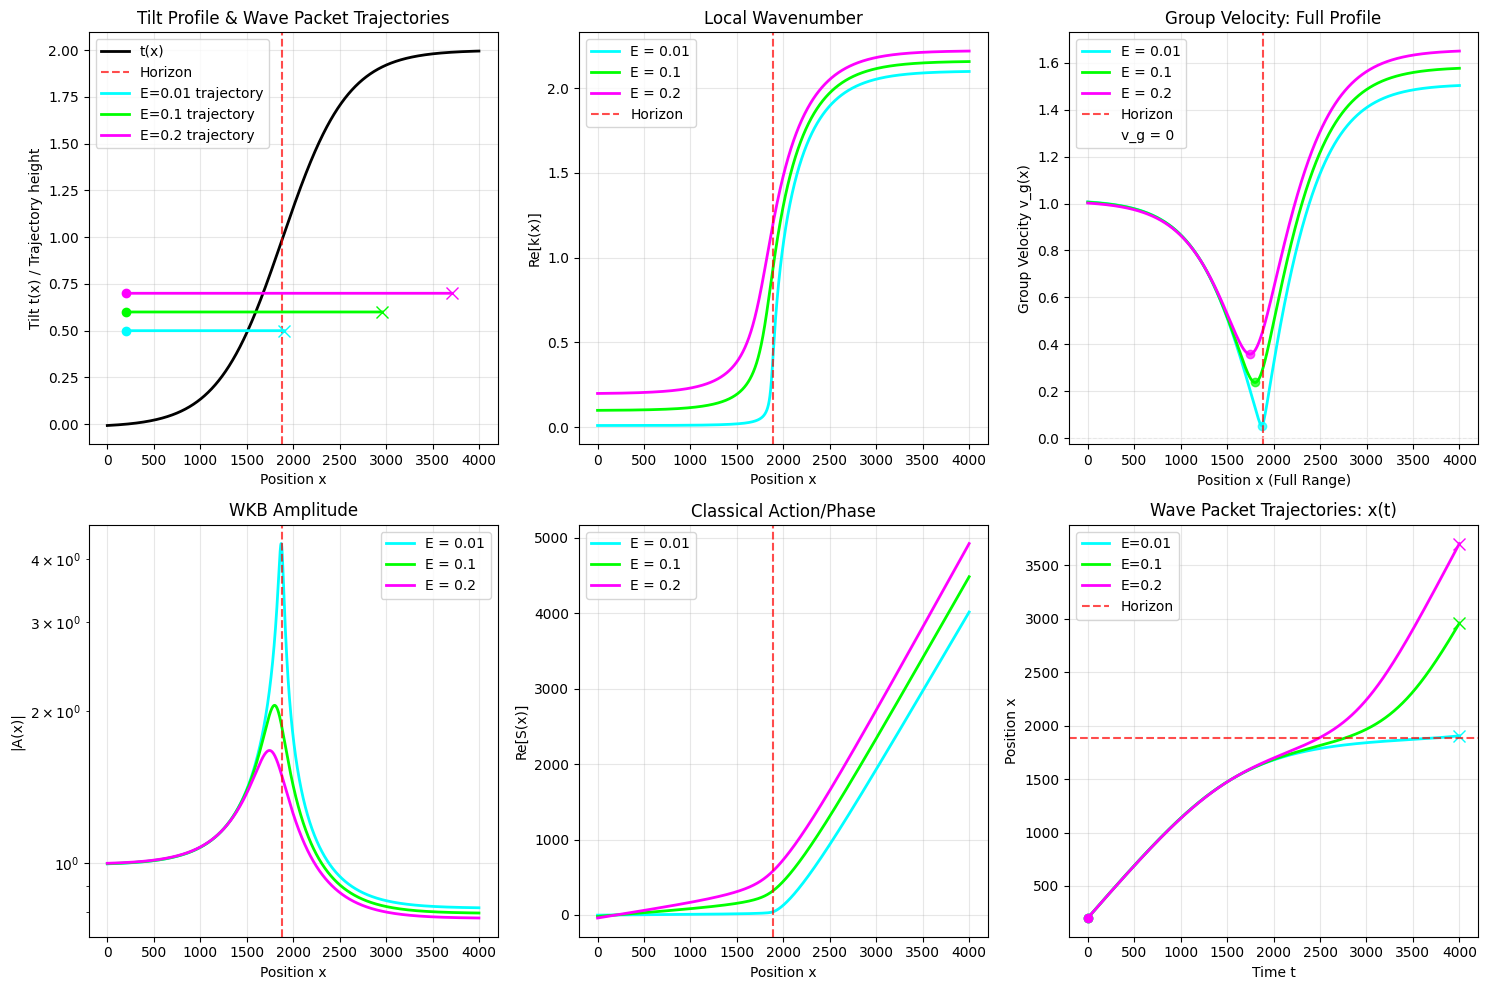


PURE WKB ANALYSIS SUMMARY - MODEL 2
Model: E = √(sin²k + (1-cos k)²) - V(x)sin(k)
Horizon position: x = 1884.5
Energies analyzed: [0.01, 0.1, 0.2]

Energy E = 0.01:
  Valid WKB points: 4000/4000 (100.0%)
  Max amplitude: |A|_max = 4.29e+00
  Trajectory end position: x_final = 1905.8+0.0j

Energy E = 0.1:
  Valid WKB points: 4000/4000 (100.0%)
  Max amplitude: |A|_max = 2.05e+00
  Trajectory end position: x_final = 2960.0+0.0j

Energy E = 0.2:
  Valid WKB points: 4000/4000 (100.0%)
  Max amplitude: |A|_max = 1.67e+00
  Trajectory end position: x_final = 3705.1+0.0j



In [4]:
# Main Plotting Results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Tilt profile with trajectories
ax = axes[0, 0]
ax.plot(x, wkb_results[E_values[0]]['t_profile'], 'black', linewidth=2, label='t(x)')
ax.axvline(x_horizon, color='red', linestyle='--', alpha=0.7, label='Horizon')

if trajectory_results:
    for i, E in enumerate(E_values):
        if E in trajectory_results:
            traj = trajectory_results[E]
            ax.plot(traj['x_traj'], np.ones_like(traj['x_traj']) * (0.5 + i*0.1), 
                   color=colors[i], linewidth=2, label=f'E={E} trajectory')
            ax.plot(traj['x_traj'][0], 0.5 + i*0.1, 'o', color=colors[i], markersize=6)
            ax.plot(traj['x_traj'][-1], 0.5 + i*0.1, 'x', color=colors[i], markersize=8)
ax.set_xlabel('Position x')
ax.set_ylabel('Tilt t(x) / Trajectory height')
ax.set_title('Tilt Profile & Wave Packet Trajectories')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Local wavenumber (real part) - Focus on x < horizon, positive k only
ax = axes[0, 1]
for i, E in enumerate(E_values):
    k_real = np.real(wkb_results[E]['k_local'])
    valid_mask = ~np.isnan(k_real)
    
    if np.any(valid_mask):
        x_filtered = x[valid_mask]
        k_filtered = k_real[valid_mask]
        ax.plot(x_filtered, k_filtered, color=colors[i], linewidth=2, label=f'E = {E}')

ax.axvline(x_horizon, color='red', linestyle='--', alpha=0.7, label='Horizon')
ax.set_xlabel('Position x')
ax.set_ylabel('Re[k(x)]')
ax.set_title('Local Wavenumber')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Group velocity vs Position (FOCUSED on x < horizon region)
ax = axes[0, 2]
for i, E in enumerate(E_values):
    v_g_real = np.real(wkb_results[E]['v_g'])
    valid_mask = ~np.isnan(v_g_real)
    x_focused = x[valid_mask]
    v_g_focused = v_g_real[valid_mask]
    
    ax.plot(x_focused, v_g_focused, color=colors[i], linewidth=2, label=f'E = {E}')
    
    if len(v_g_focused) > 0:
        min_idx = np.argmin(v_g_focused) # Mark the minimum v_g point
        ax.plot(x_focused[min_idx], v_g_focused[min_idx], 'o', 
               color=colors[i], markersize=6, alpha=0.7)

ax.axvline(x_horizon, color='red', linestyle='--', alpha=0.7, label='Horizon')
ax.axhline(0, color='white', linestyle=':', alpha=0.5, label='v_g = 0')
ax.set_xlabel('Position x (Full Range)') 
ax.set_ylabel('Group Velocity v_g(x)')
ax.set_title('Group Velocity: Full Profile') 
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: WKB amplitude (shows divergence at horizon)
ax = axes[1, 0]
for i, E in enumerate(E_values):
    amplitude = np.abs(wkb_results[E]['A_amplitude'])
    amplitude_masked = np.ma.array(amplitude, mask=np.isnan(amplitude))
    ax.plot(x, amplitude_masked, color=colors[i], linewidth=2, label=f'E = {E}')
ax.axvline(x_horizon, color='red', linestyle='--', alpha=0.7)
ax.set_xlabel('Position x')
ax.set_ylabel('|A(x)|')
ax.set_title('WKB Amplitude')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: Phase S(x)
ax = axes[1, 1]
for i, E in enumerate(E_values):
    phase = np.real(wkb_results[E]['S_phase'])
    phase_masked = np.ma.array(phase, mask=np.isnan(phase))
    ax.plot(x, phase_masked, color=colors[i], linewidth=2, label=f'E = {E}')
ax.axvline(x_horizon, color='red', linestyle='--', alpha=0.7)
ax.set_xlabel('Position x')
ax.set_ylabel('Re[S(x)]')
ax.set_title('Classical Action/Phase')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: Wave Packet Trajectories
ax = axes[1, 2]
if trajectory_results:
    for i, E in enumerate(E_values):
        if E in trajectory_results:
            traj = trajectory_results[E]
            ax.plot(traj['t_traj'], traj['x_traj'], color=colors[i], linewidth=2, label=f'E={E}')
            
            if len(traj['t_traj']) > 0:
                ax.plot(traj['t_traj'][0], traj['x_traj'][0], 'o', color=colors[i], markersize=6)
                ax.plot(traj['t_traj'][-1], traj['x_traj'][-1], 'x', color=colors[i], markersize=8)
    
    ax.axhline(x_horizon, color='red', linestyle='--', alpha=0.7, label='Horizon')
    ax.set_xlabel('Time t')
    ax.set_ylabel('Position x')
    ax.set_title('Wave Packet Trajectories: x(t)')
    ax.legend()
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No trajectory data', 
            ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Wave Packet Trajectories')

plt.tight_layout()
plt.show()

# Summary
print(f"\n{'='*60}")
print("PURE WKB ANALYSIS SUMMARY - MODEL 2")
print(f"{'='*60}")
print(f"Model: E = √(sin²k + (1-cos k)²) - V(x)sin(k)")  # Changed model
print(f"Horizon position: x = {x_horizon:.1f}")
print(f"Energies analyzed: {E_values}")
print()

for i, E in enumerate(E_values):
    result = wkb_results[E]
    
    valid_k = np.sum(~np.isnan(result['k_local']))
    total_points = len(result['k_local'])
    
    print(f"Energy E = {E}:")
    print(f"  Valid WKB points: {valid_k}/{total_points} ({100*valid_k/total_points:.1f}%)")
    print(f"  Max amplitude: |A|_max = {np.nanmax(np.abs(result['A_amplitude'])):.2e}")
    print(f"  Trajectory end position: x_final = {trajectory_results[E]['x_traj'][-1]:.1f}" if E in trajectory_results else "  No trajectory calculated")
    print()